# Presentación del Notebook
## Transformación del Dataset Semanal para la Familia BOLLERIA

Este notebook forma parte del proyecto de forecasting de ventas para un negocio de hostelería enfocado en productos de cafetería y panadería en una zona turística.

Después de realizar un análisis exploratorio exhaustivo (EDA), identificamos que la familia **BOLLERIA** presenta un comportamiento estacional muy marcado, con incrementos significativos en verano y los fines de semana. Por ello, hemos decidido centrar el desarrollo del modelo predictivo en esta categoría concreta.

## ¿Qué se realiza en este notebook?

- **Transformación del dataset diario en un dataset semanal**, agregando las ventas y las principales variables exógenas que pueden influir en la demanda.
- Generación de variables adicionales que capturan la estacionalidad de forma más eficiente, como las representaciones cíclicas de la semana del año.
- **Filtrado específico de la familia BOLLERIA** para centrar el análisis y la futura predicción en esta categoría.
- Validación visual del comportamiento de las ventas semanales.
- Finalmente, **guardamos el dataset semanal de BOLLERIA listo para el desarrollo del modelo de predicción**, almacenándolo en la carpeta `processed` para garantizar trazabilidad y reutilización.

---

Este notebook constituye un paso clave en la preparación de los datos, permitiendo que la siguiente fase de **ingeniería de características avanzadas y modelado** se pueda abordar con una base de datos bien estructurada, limpia y enfocada al objetivo.


# Paso 0: Cargar datos

In [2]:
import pandas as pd
import os

archivos = [
    "../data/interim/validated_range_fecha_familia_20250630.parquet"
 ]
# Cargar los datos de cada archivo en una lista de DataFrames
dfs = []
for archivo in archivos:
    if os.path.exists(archivo):
        df = pd.read_parquet(archivo)
        dfs.append(df)
    else:
        print(f"Archivo no encontrado: {archivo}")

# Mensajes de confirmación de que se cargaron los archivos
for i, df in enumerate(dfs):
    print(f"Archivo {i+1} cargado con éxito: {archivos[i]} - Número de filas: {len(df)}")

Archivo 1 cargado con éxito: ../data/interim/validated_range_fecha_familia_20250630.parquet - Número de filas: 9989


# Paso 1. Añadir columna year_week al dataframe diario

In [9]:
# Asegurar formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Crear columna con el año y la semana ISO
df['year_week'] = df['fecha'].dt.isocalendar().year.astype(str) + '-' + df['fecha'].dt.isocalendar().week.astype(str).str.zfill(2)

# Opcional: columna numérica separada para semana y año
df['year'] = df['fecha'].dt.isocalendar().year
df['week_of_year'] = df['fecha'].dt.isocalendar().week

df[['fecha', 'year_week', 'year', 'week_of_year']].head()


,fecha,year_week,year,week_of_year
0,2023-01-01,2022-52,2022,52
1,2023-01-02,2023-01,2023,1
2,2023-01-02,2023-01,2023,1
3,2023-01-02,2023-01,2023,1
4,2023-01-02,2023-01,2023,1


# Paso 2: Agregación semanal

In [7]:
# Definir funciones de agregación para las exógenas
def max_agg(series):
    return series.max()

def sum_agg(series):
    return series.sum()

# Agregar ventas y variables exógenas a nivel de semana y familia
df_semanal = (
    df.groupby(['year_week', 'familia']).agg({
        'base_imponible': 'sum',
        'total': 'sum',
        'is_summer_peak': max_agg,     # Si algún día es verano, la semana es verano
        'is_easter': max_agg,          # Si algún día es Semana Santa, la semana es Semana Santa
        'is_weekend': sum_agg,         # Número de días de fin de semana en la semana
        'year': max_agg,               # Extraer el año (todos los días de la semana tienen el mismo)
        'week_of_year': max_agg        # Extraer la semana del año
    })
    .reset_index()
)

df_semanal.head()


,year_week,familia,base_imponible,total,is_summer_peak,is_easter,is_weekend,year,week_of_year
0,2022-52,cerrado,0.00,0.00,0,0,1,2022,52
1,2023-01,AÑADIDOS,8.81,9.60,0,0,2,2023,1
2,2023-01,BEBIDAS,467.96,515.00,0,0,2,2023,1
3,2023-01,BOCADILLOS,864.03,950.40,0,0,2,2023,1
4,2023-01,BOLLERIA,825.11,907.13,0,0,2,2023,1


Con esto ya tendríamos:

Suma de ventas y cantidades por semana y familia.

Variables exógenas adecuadamente agregadas para la semana.

# Paso 3: Generar columnas cíclicas para week_of_year

In [10]:
import numpy as np

# Número total de semanas en el año (aprox)
N_WEEKS = 52

# Crear variables cíclicas
df_semanal['week_of_year_sin'] = np.sin(2 * np.pi * df_semanal['week_of_year'] / N_WEEKS)
df_semanal['week_of_year_cos'] = np.cos(2 * np.pi * df_semanal['week_of_year'] / N_WEEKS)

df_semanal[['year_week', 'familia', 'week_of_year', 'week_of_year_sin', 'week_of_year_cos']].head()


,year_week,familia,week_of_year,week_of_year_sin,week_of_year_cos
0,2022-52,cerrado,52,0.0,1.0
1,2023-01,AÑADIDOS,1,0.120537,0.992709
2,2023-01,BEBIDAS,1,0.120537,0.992709
3,2023-01,BOCADILLOS,1,0.120537,0.992709
4,2023-01,BOLLERIA,1,0.120537,0.992709


# Paso 4: Filtrar el dataset semanal por la familia seleccionada

In [11]:
# Paso 4: Filtrar el dataset semanal para la familia BOLLERIA
df_bolleria = df_semanal[df_semanal['familia'] == 'BOLLERIA'].reset_index(drop=True)

df_bolleria.head()


,year_week,familia,base_imponible,total,is_summer_peak,is_easter,is_weekend,year,week_of_year,week_of_year_sin,week_of_year_cos
0,2023-01,BOLLERIA,825.11,907.13,0,0,2,2023,1,0.120537,0.992709
1,2023-02,BOLLERIA,658.40,723.76,0,0,2,2023,2,0.239316,0.970942
2,2023-03,BOLLERIA,741.40,815.01,0,0,2,2023,3,0.354605,0.935016
3,2023-04,BOLLERIA,653.64,718.58,0,0,2,2023,4,0.464723,0.885456
4,2023-05,BOLLERIA,680.46,747.94,0,0,2,2023,5,0.568065,0.822984


# Paso 5: Visualización

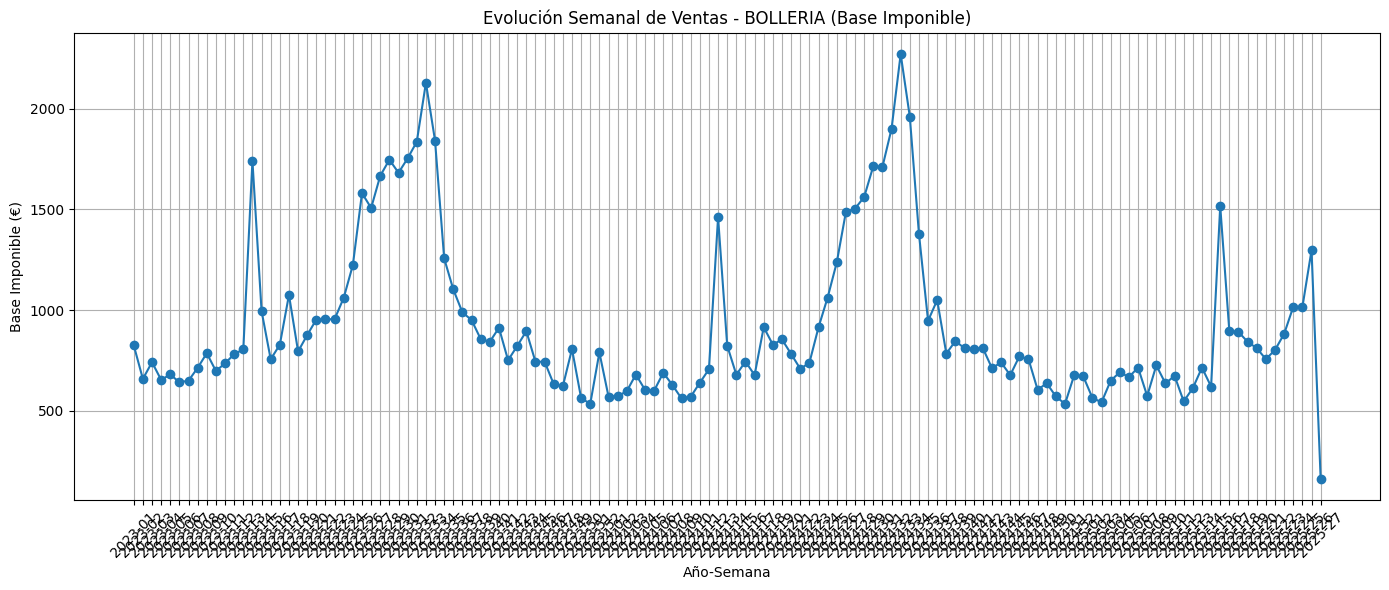

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df_bolleria['year_week'], df_bolleria['base_imponible'], marker='o')
plt.title('Evolución Semanal de Ventas - BOLLERIA (Base Imponible)')
plt.xlabel('Año-Semana')
plt.ylabel('Base Imponible (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Paso 6: Guardado en carpeta processed

In [15]:
import os

# Crear la ruta si no existe
processed_dir = '../data/processed'
os.makedirs(processed_dir, exist_ok=True)

# Guardar el dataset procesado
df_bolleria.to_parquet(
    os.path.join(processed_dir, 'ts_df_bolleria_semanal.parquet'),
    index=False
)

print("Dataset ts_df_bolleria_semanal guardado correctamente en 'data/processed'")


Dataset ts_df_bolleria_semanal guardado correctamente en 'data/processed'
